In [1]:
import pickle 
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# preprocess 
from sklearn.compose import ColumnTransformer

# pipline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import  SMOTE

# Set up nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from nltk.tokenize import word_tokenize

# MODEL 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import re
from tqdm.auto import tqdm

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\leo\AppData\Roaming\nltk_data...


True

In [4]:
from underthesea import word_tokenize, pos_tag, sent_tokenize, sentiment

In [5]:
from collections import defaultdict, Counter

In [6]:
def get_top_duplicated_words(word_list, top_n=5):
    word_count_dict = Counter(word_list)

    # Get the top N duplicated words
    top_duplicated_words = word_count_dict.most_common(top_n)

    return top_duplicated_words

In [7]:
def create_word_count_dictionary(word_list):
    word_count_dict = defaultdict(int)

    # Count the occurrences of each word
    for word in word_list:
        word_count_dict[word] += 1

    # Convert the defaultdict to a regular dictionary
    word_count_dict = dict(word_count_dict)

    return word_count_dict

In [8]:
def extract_adjectives_vietnamese(comment):
    # Perform part-of-speech tagging
    tagged_words = pos_tag(comment)

    # Extract adjectives
    adjectives = [word for word, pos in tagged_words if pos == 'A']

    return adjectives

In [9]:
def create_adj_wordcloud(df):
    type_comment = df['result'].head(1).values[0].upper()
    full_adj_word = []
    for k, text in tqdm(df['clean_review'].items(),f"Extract Adjective word from {type_comment}"):
        if isinstance(text,str):
            word_ls = extract_adjectives_vietnamese(text)
            full_adj_word.extend(word_ls)
    
    _comments = ' '.join(full_adj_word)
    #print(_comments)
    #Generate word cloud from comments
    wc_pos = WordCloud(background_color='white',
                       collocations=False,
                       max_words=50).generate(_comments)
    return full_adj_word, wc_pos

In [10]:
def restaurant_sentiment_analysis(final_df, id_res=None, top_words: int = 5):
    global res_df
    # ---- FIRST STEP: SELECT RESTAURANT ---
    if id_res:
        id_selected = id_res
    else:
        name_selected = input("Please type keyword of restaurant:")
        filter_ = res_df['Restaurant'].str.findall(rf'{name_selected}').apply(lambda x: len(x) > 0)

        with pd.option_context('display.max_rows', 30,
                               'display.max_columns', 10,
                               'display.precision', 3,
                               'display.width', None,
                               'display.max_colwidth', None
                               ):
            display(res_df.loc[filter_, ['ID', 'Restaurant', 'street', 'ward', 'district']])

        # Select ID from above restaurant
        id_selected = int(input("Please select restaurant ID from above restaurants:"))

    # Validate the restaurant
    validation_res = res_df['ID'] == id_selected
    if not any(validation_res):
        print("Dont find this restaurant, please choose again")
        return None
    else:
        # OVERVIEW DATA
        # Extract ratings and comments
        selected_res = final_df[final_df['ID'] == id_selected]
        restaurant_name = selected_res['Restaurant'].values[0]
        type_restaurant = selected_res['type_restaurant'].values[0]
        rating_score = selected_res['rating_scaler'].values[0]
        price = selected_res['avg_price'].values[0]
        address = f"{selected_res['street'].values[0]} {str(selected_res['ward'].values[0])} District {selected_res['district'].values[0]}"

        print(">>> OVERVIEW DATA")
        print("Restaurant name:", restaurant_name)
        print("Type restaurant:", type_restaurant)
        print("Average Rating:", round(rating_score, 2))
        print("Average Price:", price)
        print("Address:", address)

        # Extract Positive Negative and Neutral
        df_pos = selected_res[selected_res['result'] == 'positive']
        df_neg = selected_res[selected_res['result'] == 'negative']
        df_neu = selected_res[selected_res['result'] == 'neutral']

        wc_ls = []
        full_word_ls = []
        for i, df in enumerate([df_pos, df_neg, df_neu]):
            if df.shape[0] > 0:
                if i == 0:
                    name = 'POSITIVE'
                elif i == 1:
                    name = 'NEGATIVE'
                else:
                    name = 'NEUTRAL'

                word_ls, pos_wc = create_adj_wordcloud(df=df)
                print("--- Succeed to create WordCloud")
                wc_ls.append({'name': name, 'wordcloud': pos_wc})
                full_word_ls.append({'name': name, 'words': word_ls})
            else:
                if i == 0:
                    name = 'POSITIVE'
                elif i == 1:
                    name = 'NEGATIVE'
                else:
                    name = 'NEUTRAL'
                print(f"\n>>> There is not type **{name}** in DataFrame")

        # DISPLAY WORDCLOUD
        fig = plt.figure(figsize=(15, 7))
        # setting values to rows and column variables
        columns = len(wc_ls)
        for i in range(columns):
            # Title name:
            name = wc_ls[i]['name']
            # Adds a subplot at the 1st position
            fig.add_subplot(1, columns, i + 1)

            # showing image
            plt.imshow(wc_ls[i]['wordcloud'])
            plt.axis('off')
            plt.title(f"WordCloud of {name} review")

        # DISPLAY TOP WORD in each class
        print("\n\n>>> GET TOP 5 WORDS OCCURING MOST IN EACH CLASS:\n")
        for kind in full_word_ls:
            name = kind['name']
            concat_list = get_top_duplicated_words(kind['words'], top_n=top_words)
            print(f'{name}: {concat_list}')

        # DISPLAY RATE OF EACH TYPE REVIEW BY MONTH
        palette = sns.color_palette('husl', n_colors=3)
        fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
        sns.lineplot(x=df_pos['date_review'].dt.month,
                     y=df_pos['rating_scaler'],
                     color=palette[0],
                     label='Positive',
                     ax=ax[0])
        ax[0].set_ylabel("Rating")

        sns.lineplot(x=df_neg['date_review'].dt.month,
                     y=df_neg['rating_scaler'],
                     color=palette[1],
                     label='Negative',
                     ax=ax[1])
        ax[1].set_ylabel("Rating")

        sns.lineplot(x=df_neu['date_review'].dt.month,
                     y=df_neu['rating_scaler'],
                     color=palette[2],
                     label='Neutral',
                     ax=ax[2])
        ax[2].set_ylabel("Rating")

        # Set a big title for the entire figure
        fig.suptitle('Rating of Type Line Thourgh by Month', fontsize=16, y=1.02)
        plt.xlabel('Review Month')
        fig.tight_layout()
        plt.show()

# Export Dataframe

## Concept: 
Entering a restaurant name will display its average rating, address, price level, and concurrently generate a word cloud of customer comments.

# Overview Data

In [11]:
final_df = pd.read_csv('../Clean_data/combine_review_res.csv')
final_df['date_review'] = pd.to_datetime(final_df['date_time'])

res_df = pd.read_csv('../Clean_data/clean_restaurant.csv')

In [12]:
final_df = final_df.drop(columns='date_time')

In [16]:
res_df['ID'].values[0]

1

## Pivot for review evaluation:

In [107]:
pivot_count_res = pd.pivot_table(data=final_df,
                                 index='ID',
                                 columns=['result'],
                                 values='clean_review',
                                 aggfunc='count').reset_index()
pivot_count_res.columns = ['res_id', 'count_negative','count_postive','count_neutral']

In [108]:
pivot_count_res.head()

,res_id,count_negative,count_postive,count_neutral
0,1,18.0,35.0,46.0
1,2,NaN,1.0,NaN
2,3,13.0,44.0,43.0
3,4,5.0,4.0,5.0
4,5,1.0,6.0,13.0


In [109]:
pivot_rating_res = pd.pivot_table(data=final_df,
                                  index='ID',
                                  columns=['rating_category'],
                                  values='clean_review',
                                  aggfunc='count').reset_index()
pivot_rating_res.columns = ['res_id', 'count_low_rate','count_high_rate','count_medium_rate']

In [110]:
pivot_rating_res.head()

,res_id,count_low_rate,count_high_rate,count_medium_rate
0,1,22.0,57.0,20.0
1,2,NaN,NaN,1.0
2,3,15.0,60.0,25.0
3,4,5.0,6.0,3.0
4,5,2.0,14.0,4.0


In [111]:
mean_rate_res = final_df.groupby('IDRestaurant',as_index=False).agg({'rating_scaler':"mean"})
mean_rate_res.columns = ['res_id', 'mean_rate']

In [112]:
summary_df = pd.merge(left=pivot_count_res,right=pivot_rating_res,on='res_id')
summary_df = summary_df.merge(right=mean_rate_res,on='res_id')

In [113]:
summary_df.nlargest(n=10,columns=['count_postive'])

,res_id,count_negative,count_postive,count_neutral,count_low_rate,count_high_rate,count_medium_rate,mean_rate
663,917,NaN,94.0,6.0,NaN,98.0,2.0,9.9046
1078,1444,NaN,70.0,28.0,NaN,32.0,66.0,6.8302
185,193,18.0,65.0,17.0,19.0,46.0,35.0,6.1570
292,424,12.0,65.0,23.0,12.0,46.0,42.0,6.4288
349,486,NaN,65.0,29.0,NaN,36.0,58.0,7.1344
937,1220,NaN,64.0,34.0,NaN,38.0,60.0,7.0336
140,147,NaN,62.0,38.0,NaN,40.0,60.0,7.1632
532,674,1.0,62.0,37.0,4.0,64.0,32.0,6.9670
808,1083,NaN,61.0,38.0,NaN,43.0,56.0,7.2622
1087,1463,6.0,61.0,32.0,6.0,44.0,49.0,7.1830


# Sentiment Analysis For Specific Restaurant

Please type keyword of restaurant: Gà


,ID,Restaurant,street,ward,district
0,1,Gà Rán & Burger McDonald's Đa Kao,2 - 6 Bis Điện Biên Phủ,NaN,1
8,9,Gà Rán KFC - Nguyễn Văn Giai,2 Nguyễn Huy Tự,P. Đa Kao,1
10,11,"Home Mì - Mì Ý, Salad & Gà Chiên - Shop Online",65A Cách Mạng Tháng 8,P. Bến Thành,1
17,18,Xôi Gà Tân Định 310 - Hai Bà Trưng,297 Hai Bà Trưng,P. Tân Định,1
29,30,Con Gà Mái - Cơm Gà Phú Yên - Trần Cao Vân,21A Trần Cao Vân,P. Đa Kao,1
...,...,...,...,...,...
1559,1577,Cơm Gà Ngũ Vị CN3 - Ship 24H,7A Thạnh Lộc 29,P. Thạnh Lộc,12
1561,1579,Gà Rán Chicken Plus - Nguyễn Văn Quá,627A Nguyễn Văn Quá,P. Đông Hưng Thuận,12
1562,1580,Cơm Gà Đệ Nhất - Tô Ký,12/6 Tô Ký,P. Tân Chánh Hiệp,12
1591,1609,"3 Râu - Gà Rán, Pizza & Trà Sữa - 107 Nguyễn Văn Quá",107 Nguyễn Văn Quá,P. Đông Hưng Thuận,12


Please select restaurant ID from above restaurants: 18


>>> OVERVIEW DATA
Restaurant name: Xôi Gà Tân Định 310 - Hai Bà Trưng
Type restaurant: Casual
Average Rating: 6.4
Average Price: 20000.0
Address: 297 Hai Bà Trưng  P. Tân Định District 1


Extract Adjective word from POSITIVE: 0it [00:00, ?it/s]

--- Succeed to create WordCloud


Extract Adjective word from NEGATIVE: 0it [00:00, ?it/s]

--- Succeed to create WordCloud


Extract Adjective word from NEUTRAL: 0it [00:00, ?it/s]

--- Succeed to create WordCloud


>>> GET TOP 5 WORDS OCCURING MOST IN EACH CLASS:

POSITIVE: [('ngon', 21), ('nhiều', 13), ('khô', 10), ('lâu', 6), ('mặn', 6)]
NEGATIVE: [('khô', 4), ('nhiều', 3), ('ít', 2), ('chắc', 2), ('tệ', 2)]
NEUTRAL: [('ít', 20), ('khô', 18), ('nhiều', 18), ('ngon', 13), ('đông', 10)]


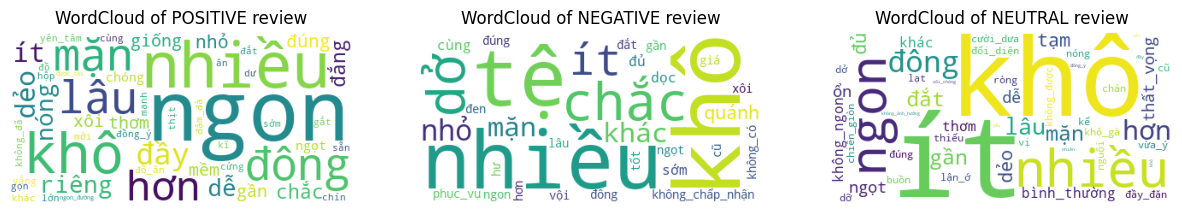

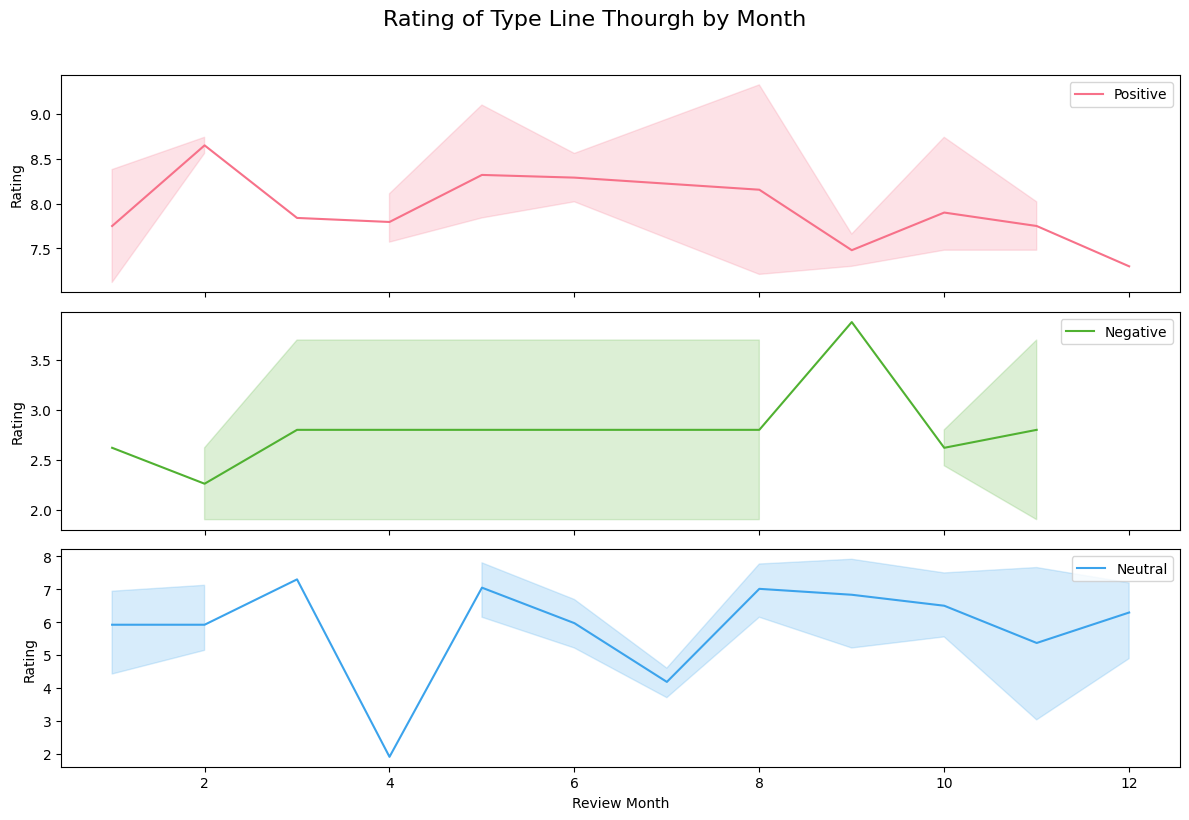

In [152]:
restaurant_sentiment_analysis(final_df=final_df,id_res=None,top_words=5)

## BreakDown function

In [122]:
#Extract ratings and comments
selected_res = final_df[final_df['ID']==1]
selected_res.head(1)

,ID,Restaurant,street,ward,district,start_time,end_time,IDRestaurant,user_id,rating_scaler,clean_review,under_sentiment,rating_category,sentiment_encode,rating_encode,result,avg_price,type_restaurant,date_review
0,1,Gà Rán & Burger McDonald's Đa Kao,2 - 6 Bis Điện Biên Phủ,NaN,1,00:00,23:59,1,8670,5.68,gà chiên còn sống rất,negative,medium,0.0,2.0,neutral,125000.0,Casual,2023-12-20 21:13:00


>>> OVERVIEW DATA
Restaurant name: Gà Rán & Burger McDonald's Đa Kao
Type restaurant: Casual
Average Rating: 5.68
Average Price: 125000.0
Address: 2 - 6 Bis Điện Biên Phủ nan District 1


Extract Adjective word from POSITIVE: 0it [00:00, ?it/s]

--- Succeed to create WordCloud


Extract Adjective word from NEGATIVE: 0it [00:00, ?it/s]

--- Succeed to create WordCloud


Extract Adjective word from NEUTRAL: 0it [00:00, ?it/s]

--- Succeed to create WordCloud


>>> GET TOP 5 WORDS OCCURING MOST IN EACH CLASS:

POSITIVE: [('nhiều', 26), ('ngon', 24), ('hơn', 16), ('khác', 12), ('khô', 12)]
NEGATIVE: [('khô', 5), ('khác', 5), ('nhiều', 4), ('đúng', 3), ('đủ', 3)]
NEUTRAL: [('nhiều', 12), ('lớn', 11), ('ngon', 9), ('khác', 8), ('hơn', 8)]


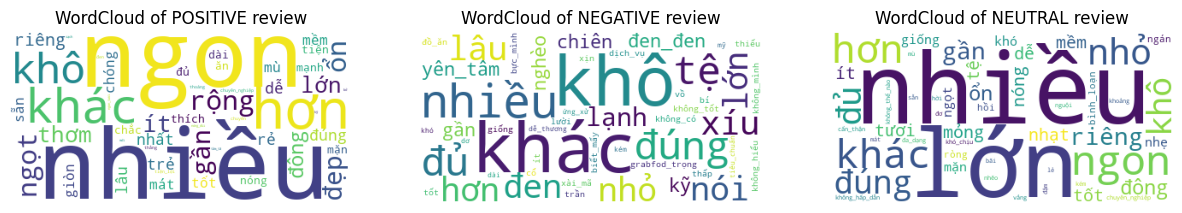

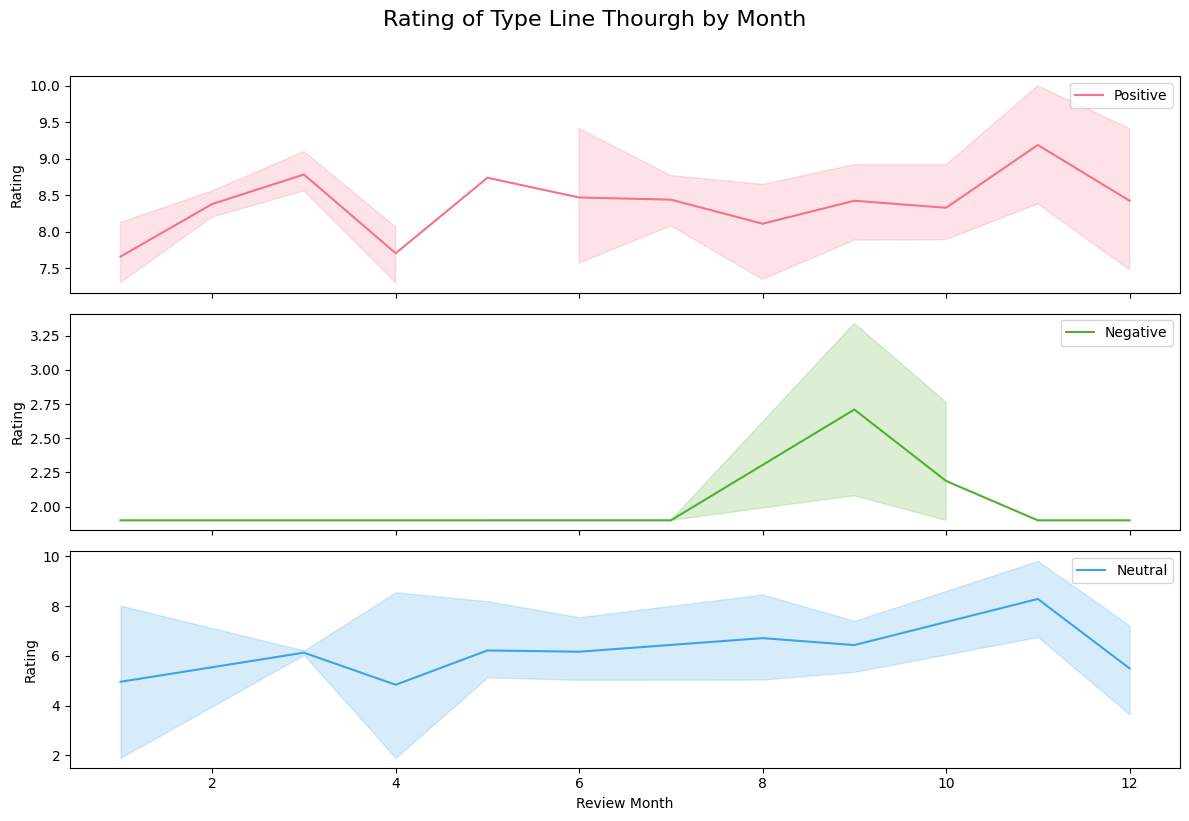

In [143]:
# OVERVIEW DATA
#Extract ratings and comments
selected_res = final_df[final_df['ID']==1]
restaurant_name = selected_res['Restaurant'].values[0]
type_restaurant = selected_res['type_restaurant'].values[0]
rating_score = selected_res['rating_scaler'].values[0]
price = selected_res['avg_price'].values[0]
address = f"{selected_res['street'].values[0]} {str(selected_res['ward'].values[0])} District {selected_res['district'].values[0]}"

print(">>> OVERVIEW DATA")
print("Restaurant name:",restaurant_name)
print("Type restaurant:",type_restaurant)
print("Average Rating:", round(rating_score,2))
print("Average Price:", price)
print("Address:", address)

# Extract Positive Negative and Neutral
df_pos = selected_res[selected_res['result'] == 'positive']
df_neg = selected_res[selected_res['result'] == 'negative']
df_neu = selected_res[selected_res['result'] == 'neutral']

wc_ls = []
full_word_ls = []
for i, df in enumerate([df_pos,df_neg,df_neu]):
    if df.shape[0]>0:
        if i == 0:
            name = 'POSITIVE'
        elif i == 1:
            name = 'NEGATIVE'
        else:
            name = 'NEUTRAL'
        
        word_ls, pos_wc = create_adj_wordcloud(df=df)
        print("--- Succeed to create WordCloud")
        wc_ls.append({'name':name,'wordcloud':pos_wc})
        full_word_ls.append({'name':name,'words':word_ls})
    else:
        if i == 0:
            name = 'POSITIVE'
        elif i == 1:
            name = 'NEGATIVE'
        else:
            name = 'NEUTRAL'
        print(f"\n>>> There is not type **{name}** in DataFrame")

# DISPLAY WORDCLOUD
fig = plt.figure(figsize=(15, 7))
# setting values to rows and column variables 
columns = len(wc_ls)
for i in range(columns):
    # Title name:
    name = wc_ls[i]['name']
    # Adds a subplot at the 1st position 
    fig.add_subplot(1, columns, i+1) 
      
    # showing image 
    plt.imshow(wc_ls[i]['wordcloud']) 
    plt.axis('off') 
    plt.title(f"WordCloud of {name} review")

# DISPLAY TOP WORD in each class
print("\n\n>>> GET TOP 5 WORDS OCCURING MOST IN EACH CLASS:\n")
for kind in full_word_ls:
    name = kind['name']
    concat_list = get_top_duplicated_words(kind['words'],top_n=5)
    print(f'{name}: {concat_list}')

# DISPLAY RATE OF EACH TYPE REVIEW BY MONTH
palette = sns.color_palette('husl', n_colors=3)
fig, ax = plt.subplots(3,1, figsize=(12,8), sharex=True)
sns.lineplot(x=df_pos['date_review'].dt.month, 
             y=df_pos['rating_scaler'],
             color=palette[0],
             label='Positive',
             ax=ax[0])
ax[0].set_ylabel("Rating")

sns.lineplot(x=df_neg['date_review'].dt.month, 
             y=df_neg['rating_scaler'],
             color=palette[1],
             label='Negative',
             ax=ax[1])
ax[1].set_ylabel("Rating")

sns.lineplot(x=df_neu['date_review'].dt.month, 
             y=df_neu['rating_scaler'],
             color=palette[2],
             label='Neutral',
             ax=ax[2])
ax[2].set_ylabel("Rating")

# Set a big title for the entire figure
fig.suptitle('Rating of Type Line Thourgh by Month', fontsize=16, y=1.02)
plt.xlabel('Review Month')
fig.tight_layout()
plt.show()

In [124]:
selected_res.head(3)

,ID,Restaurant,street,ward,district,start_time,end_time,IDRestaurant,user_id,rating_scaler,clean_review,under_sentiment,rating_category,sentiment_encode,rating_encode,result,avg_price,type_restaurant,date_review
0,1,Gà Rán & Burger McDonald's Đa Kao,2 - 6 Bis Điện Biên Phủ,NaN,1,00:00,23:59,1,8670,5.68,gà chiên còn sống rất,negative,medium,0.0,2.0,neutral,125000.0,Casual,2023-12-20 21:13:00
1,1,Gà Rán & Burger McDonald's Đa Kao,2 - 6 Bis Điện Biên Phủ,NaN,1,00:00,23:59,1,11063,5.50,đã ăn ăn đồng_ý,negative,medium,0.0,2.0,neutral,125000.0,Casual,2023-09-25 15:43:00
2,1,Gà Rán & Burger McDonald's Đa Kao,2 - 6 Bis Điện Biên Phủ,NaN,1,00:00,23:59,1,9541,5.50,đã thư rất ngon,positive,medium,1.0,2.0,neutral,125000.0,Casual,2023-06-24 11:11:00


In [125]:
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 5 to 99
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID                47 non-null     int64         
 1   Restaurant        47 non-null     object        
 2   street            47 non-null     object        
 3   ward              0 non-null      object        
 4   district          47 non-null     int64         
 5   start_time        47 non-null     object        
 6   end_time          47 non-null     object        
 7   IDRestaurant      47 non-null     int64         
 8   user_id           47 non-null     int64         
 9   rating_scaler     47 non-null     float64       
 10  clean_review      46 non-null     object        
 11  under_sentiment   38 non-null     object        
 12  rating_category   47 non-null     object        
 13  sentiment_encode  47 non-null     float64       
 14  rating_encode     47 non-nul

# Apply model to predict Comment:

In [163]:
with open('../Clean_data/predict_review_model.pkl', 'rb') as file:
    clf_model = pickle.load(file)

In [156]:
test_review = 'Món này không ngon'

In [159]:
def pre_process(text):
    lemma = WordNetLemmatizer()

    # Get stop word
    with open('../DATA_shopeefood/files/vietnamese-stopwords.txt', 'r', encoding="utf8") as file:
        stop_words = file.read().split('\n')
    
    ## tokenize => slpit words into list by space
    tokenized = word_tokenize(text)
    
    ## stopwords removal
    stw = [word for word in tokenized if word not in stop_words]
    
    ## lower
    lower = [word.lower() for word in stw]
    
    ## lemma
    result=[lemma.lemmatize(word) for word in lower]
    
    #### join to make a sentence
    results = " ".join(result)
    
    return results

In [161]:
clean_text = pre_process(text=test_review)
clean_text

'món không ngon'

In [170]:
test_data = pd.DataFrame([test_review],columns=['clean_review'])
test_data

,clean_review
0,Món này không ngon


In [165]:
clf_model.steps

[('count_vector', CountVectorizer(stop_words='english')),
 ('oversampling', SMOTE(random_state=42)),
 ('naive', MultinomialNB())]

In [171]:
# preprocess data
tqdm.pandas(desc='Preprocess Text') 
test_data_pre = test_data.progress_apply(lambda x: pre_process(x['clean_review']),axis=1)


# remove some specific digit 
test_data_pre =(test_data_pre
              .str.replace(pat=r'[@:\(\)\-!=?\.\\,]',regex=True,repl='')
              .str.replace(pat='from',repl='')
              .str.replace(pat=r'\s+',repl=' ',regex=True))

Preprocess Text:   0%|          | 0/1 [00:00<?, ?it/s]

In [173]:
test_data_pre

0    món không ngon
dtype: object

In [174]:
clf_model.predict_proba(test_data_pre)

array([[0.07181194, 0.42680424, 0.50138382]])